# Calculation of control fields for QFT gate on two qubits using L-BFGS-B algorithm

Alexander Pitchford (agp1@aber.ac.uk)

In [74]:
cd /Users/benrosand/oct-qiskit-pulse

/Users/benrosand/oct-qiskit-pulse
/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Imports

In [75]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor, hadamard_transform, basis
from qutip.qip.algorithms import qft
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen
from src.qutip_helper import convert_qutip_ham
from src.helper import *
from qiskit import IBMQ
from qutip.qip.device import Processor
from qiskit.pulse import Play, SamplePulse

from qiskit.providers.aer.pulse.system_models.hamiltonian_model import HamiltonianModel

example_name = 'QFT'

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Defining the physics

Note here that there are two controls acting on each qubit.

In [77]:
# subsystem_list=[0,1]
subsystem_list=[0,1]
single_q = True
IBMQ.load_account()

# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibmq_athens')


/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
ibmqfactory.load_account:WARNING:2020-09-08 18:53:20,288: Credentials are already in use. The existing account in the session will be replaced.


In [78]:
# HamiltonianModel.from_dict(backend.configuration().hamiltonian, subsystem_list=[0])._system[1][0].full()
print(backend.configuration().hamiltonian['h_latex'])


\begin{align} \mathcal{H}/\hbar = & \sum_{i=0}^{4}\left(\frac{\omega_{q,i}}{2}(\mathbb{I}-\sigma_i^{z})+\frac{\Delta_{i}}{2}(O_i^2-O_i)+\Omega_{d,i}D_i(t)\sigma_i^{X}\right) \\ & + J_{1,2}(\sigma_{1}^{+}\sigma_{2}^{-}+\sigma_{1}^{-}\sigma_{2}^{+}) + J_{3,4}(\sigma_{3}^{+}\sigma_{4}^{-}+\sigma_{3}^{-}\sigma_{4}^{+}) + J_{0,1}(\sigma_{0}^{+}\sigma_{1}^{-}+\sigma_{0}^{-}\sigma_{1}^{+}) + J_{2,3}(\sigma_{2}^{+}\sigma_{3}^{-}+\sigma_{2}^{-}\sigma_{3}^{+}) \\ & + \Omega_{d,0}(U_{0}^{(0,1)}(t))\sigma_{0}^{X} + \Omega_{d,1}(U_{1}^{(1,0)}(t)+U_{2}^{(1,2)}(t))\sigma_{1}^{X} \\ & + \Omega_{d,2}(U_{3}^{(2,1)}(t)+U_{4}^{(2,3)}(t))\sigma_{2}^{X} + \Omega_{d,3}(U_{6}^{(3,4)}(t)+U_{5}^{(3,2)}(t))\sigma_{3}^{X} \\ & + \Omega_{d,4}(U_{7}^{(4,3)}(t))\sigma_{4}^{X} \\ \end{align}
/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_

\begin{align} \mathcal{H}/\hbar = & \sum_{i=0}^{4}\left(\frac{\omega_{q,i}}{2}(\mathbb{I}-\sigma_i^{z})+\frac{\Delta_{i}}{2}(O_i^2-O_i)+\Omega_{d,i}D_i(t)\sigma_i^{X}\right) \\ & + J_{1,2}(\sigma_{1}^{+}\sigma_{2}^{-}+\sigma_{1}^{-}\sigma_{2}^{+}) + J_{3,4}(\sigma_{3}^{+}\sigma_{4}^{-}+\sigma_{3}^{-}\sigma_{4}^{+}) + J_{0,1}(\sigma_{0}^{+}\sigma_{1}^{-}+\sigma_{0}^{-}\sigma_{1}^{+}) + J_{2,3}(\sigma_{2}^{+}\sigma_{3}^{-}+\sigma_{2}^{-}\sigma_{3}^{+}) \\ & + \Omega_{d,0}(U_{0}^{(0,1)}(t))\sigma_{0}^{X} + \Omega_{d,1}(U_{1}^{(1,0)}(t)+U_{2}^{(1,2)}(t))\sigma_{1}^{X} \\ & + \Omega_{d,2}(U_{3}^{(2,1)}(t)+U_{4}^{(2,3)}(t))\sigma_{2}^{X} + \Omega_{d,3}(U_{6}^{(3,4)}(t)+U_{5}^{(3,2)}(t))\sigma_{3}^{X} \\ & + \Omega_{d,4}(U_{7}^{(4,3)}(t))\sigma_{4}^{X} \\ \end{align}


In [79]:
backend.configuration().hamiltonian['vars']['wq0'] = 0
backend.configuration().hamiltonian['vars']['wq1'] = 0
ham = convert_qutip_ham(backend, subsystem_list, False)
H_d = ham['H_d']
# ham['H_c'].pop('U2')
H_c = list(ham['H_c'].values())

n_ctrls = len(H_c)
n_ctrls
ham['H_c'].keys()

U0
not using control
U1
not using control
U2
not using control
D0
NEED TO FINISH sigx1 or 2
D1
NEED TO FINISH sigx1 or 2
/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['D0', 'D0y', 'D1', 'D1y'])

In [80]:
H_d

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.01049575  0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -2.11179348  0.          0.01484324  0.
   0.          0.          0.        ]
 [ 0.          0.01049575  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.01484324  0.          0.          0.
   0.01484324  0.          0.        ]
 [ 0.          0.          0.          0.          0.         -2.11179348
   0.          0.02099151  0.        ]
 [ 0.          0.          0.          0.          0.01484324  0.
  -2.08944214  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.02099151
   0.         -2.08944214  0.        ]
 [ 0.          0.          0.          0.          0. 

### Define the 3 level operators

In [81]:
h = hadamard_transform(1).full()

hadamard_3 = Qobj([[h[0][0],h[0][1],0],
                   [h[1][0],h[1][1],0],
                   [0,      0,      1]])
sigmax_3 =  Qobj([[0,1,0],
                  [1,0,0],
                  [0,0,1]])


# identity
# cnot = d_sum(Qobj(d_sum(identity(3), identity(3)), sigmax_3))
# cnot = d_sum(identity(6), sigmax_3)
zeros3 = Qobj(np.zeros((3,3)))
cnot = d_sum(Qobj(d_sum(identity(3), sigmax_3)), zeros3)
cnot = d_sum(Qobj(d_sum(identity(3), sigmax_3)),identity(3))
# cnot = d_sum(Qobj(d_sum(identity(3),zeros)), sigmax_3)
U_0 = tensor(identity(3), identity(3))
U_targ = Qobj(cnot)
U_targ = d_sum((d_sum(sigmax_3, identity(3))),identity(3))
# U_targ

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-81-b755bf3d8457>:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  h = hadamard_transform(1).full()


In [82]:
U_targ

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]

### Defining the time evolution parameters

Multiple total evolution times will be tried. Using this approach, the minimum evolution time required to achieve the target fidelity could be determined (iteratively).

Note that the timeslot duration dt is fixed, and so the number of timeslots depends on the evo_time

In [83]:
# Duration of each timeslot
dt = backend.configuration().dt * 1e9
# dt = 0.02
# n_ts_list = list(np.arange(,1200,160))
n_ts_list = [480]
# n_ts_list = [512]#, 480, 560,640]
evo_times = [dt * n for n in n_ts_list]
# List of evolution times to try
# evo_times = [1, 3, 6]
n_evo_times = len(evo_times)
evo_time = evo_times[0]
n_ts = int(float(evo_time) / dt)
#Empty list that will hold the results for each evolution time
# results = list()

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Set the conditions which will cause the pulse optimisation to terminate

### Set the initial pulse type

Here the linear initial pulse type is used, simply because it results in smooth final pulses

In [84]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'LIN'

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Give an extension for output files

In [85]:
#Set to None to suppress output files
# f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)
f_ext = None

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create the optimiser objects

Here is the main difference between this and the Hadamard example. In this case we use a different pulseoptim function that just creates the objects that can be used to set the physics and configure the optimisation algorithm. This gives greater flexibility (shown here by seting different initial pulse parameters for each control) and is also more efficient when running multiple optimisations on the same system.

In [86]:
# Fidelity error target
fid_err_targ = 1e-30
# Maximum iterations for the optisation algorithm
max_iter = 2000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-30

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
optim = cpo.create_pulse_optimizer(H_d, H_c, U_0, U_targ, n_ts, evo_time, 
                amp_lbound=-.7, amp_ubound=.7, 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                optim_method='fmin_l_bfgs_b',
                method_params={'max_metric_corr':20, 'accuracy_factor':1e8},
                dyn_type='UNIT', 
                fid_params={'phase_option':'PSU'},
                init_pulse_type=p_type, 
                log_level=log_level, gen_stats=True)

# **** get handles to the other objects ****
optim.test_out_files = 0
dyn = optim.dynamics
dyn.test_out_files = 0
p_gen = optim.pulse_generator
                

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Optimise the pulse for each of the different evolution times

Here a loop is used to perform the optimisation for each of the evo_times given in the list above. The first optimisation is completed using the timeslot parameters passed when the optimisation objects are created. For the subsequent runs, the Dynamics object 'dyn' is used to set the timeslot parameters before the initial pulses are generated and optimisation is completed. Note that using this method, the dyn.initialize_controls method must be called with an array of the initial amplitudes before the optim.run_optimization method is called.

In [88]:
dt

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.2222222222222222

In [89]:
results = []
for i in range(n_evo_times):
    # Generate the tau (duration) and time (cumulative) arrays
    # so that it can be used to create the pulse generator
    # with matching timeslots
    dyn.init_timeslots()
    if i > 0:
        # Create a new pulse generator for the new dynamics
        p_gen = pulsegen.create_pulse_gen(p_type, dyn)
        
    #Generate different initial pulses for each of the controls
    init_amps = np.zeros([n_ts, n_ctrls])
    if (p_gen.periodic):
        phase_diff = np.pi / n_ctrls
        for j in range(n_ctrls):
            init_amps[:, j] = p_gen.gen_pulse(start_phase=phase_diff*j)
    elif (isinstance(p_gen, pulsegen.PulseGenLinear)):
        for j in range(n_ctrls):
            p_gen.scaling = float(j) - float(n_ctrls - 1)/2
            init_amps[:, j] = p_gen.gen_pulse()
    elif (isinstance(p_gen, pulsegen.PulseGenZero)):
        for j in range(n_ctrls):
            p_gen.offset = sf = float(j) - float(n_ctrls - 1)/2
            init_amps[:, j] = p_gen.gen_pulse()
    else:
        # Should be random pulse
        for j in range(n_ctrls):
            init_amps[:, j] = p_gen.gen_pulse()
    
    dyn.initialize_controls(init_amps)
    
    # Save initial amplitudes to a text file
    if f_ext is not None:
        pulsefile = "ctrl_amps_initial_" + f_ext
        dyn.save_amps(pulsefile)
        print("Initial amplitudes output to file: " + pulsefile)

    print("***********************************")
    print("\n+++++++++++++++++++++++++++++++++++")
    print("Starting pulse optimisation for T={}".format(evo_time))
    print("+++++++++++++++++++++++++++++++++++\n")
    result = optim.run_optimization()
    # Save final amplitudes to a text file
    if f_ext is not None:
        pulsefile = "ctrl_amps_final_" + f_ext
        dyn.save_amps(pulsefile)
        print("Final amplitudes output to file: " + pulsefile)
    
    # Report the results
    result.stats.report()
    print("Final evolution\n{}\n".format(result.evo_full_final))
    print("********* Summary *****************")
    print("Final fidelity error {}".format(result.fid_err))
    print("Final gradient normal {}".format(result.grad_norm_final))
    print("Terminated due to {}".format(result.termination_reason))
    print("Number of iterations {}".format(result.num_iter))
    print("Completed in {} HH:MM:SS.US".format(
            datetime.timedelta(seconds=result.wall_time)))
    results.append(result)
    if i+1 < len(evo_times):
        # reconfigure the dynamics for the next evo time
        evo_time = evo_times[i+1]
        n_ts = int(float(evo_time) / dt)
        dyn.tau = None
        dyn.evo_time = evo_time
        dyn.num_tslots = n_ts

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
***********************************

+++++++++++++++++++++++++++++++++++
Starting pulse optimisation for T=71.11111111111111
+++++++++++++++++++++++++++++++++++

INFO:qutip.control.optimizer:Optimising pulse(s) 

In [90]:
evo = results[0].evo_full_final
evo.tidyup(1e-3)
# len(H_c)


/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[-0.34639712+0.44377323j -0.64856551-0.5085815j   0.01749672+0.00336972j
  -0.00627858-0.01914404j -0.02770629-0.01126553j -0.03228041-0.0135655j
  -0.00985651+0.00121896j  0.01413624-0.00754271j  0.02410711+0.00121446j]
 [-0.65717045-0.49749839j -0.33992431+0.44988172j  0.0193963 +0.00500291j
   0.02120612+0.j          0.        -0.00730913j -0.03098694-0.01249227j
   0.00775361+0.01478454j -0.00872217+0.01104834j  0.01195771+0.00623223j]
 [-0.01861538+0.j         -0.01785548+0.00212143j -0.99335924-0.09678859j
  -0.00590965-0.0168083j  -0.0215716 -0.03528665j -0.00233903+0.01984534j
   0.00262373-0.00509877j  0.00577046+0.02446398j  0.00434394-0.00938665j]
 [-0.0062592 -0.02231966j  0.00539271+0.00662113j  0.01763204-0.00346566j
  -0.9113426 -0.32618478j  0.08429919-0.2283612j  -0.03724447-0.00176712j
   0.        +0.01211458j  0.03041667-0.01160161j  0.0143525 -0.00815617j]
 [ 0.0221839

### Plot the initial and final amplitudes

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


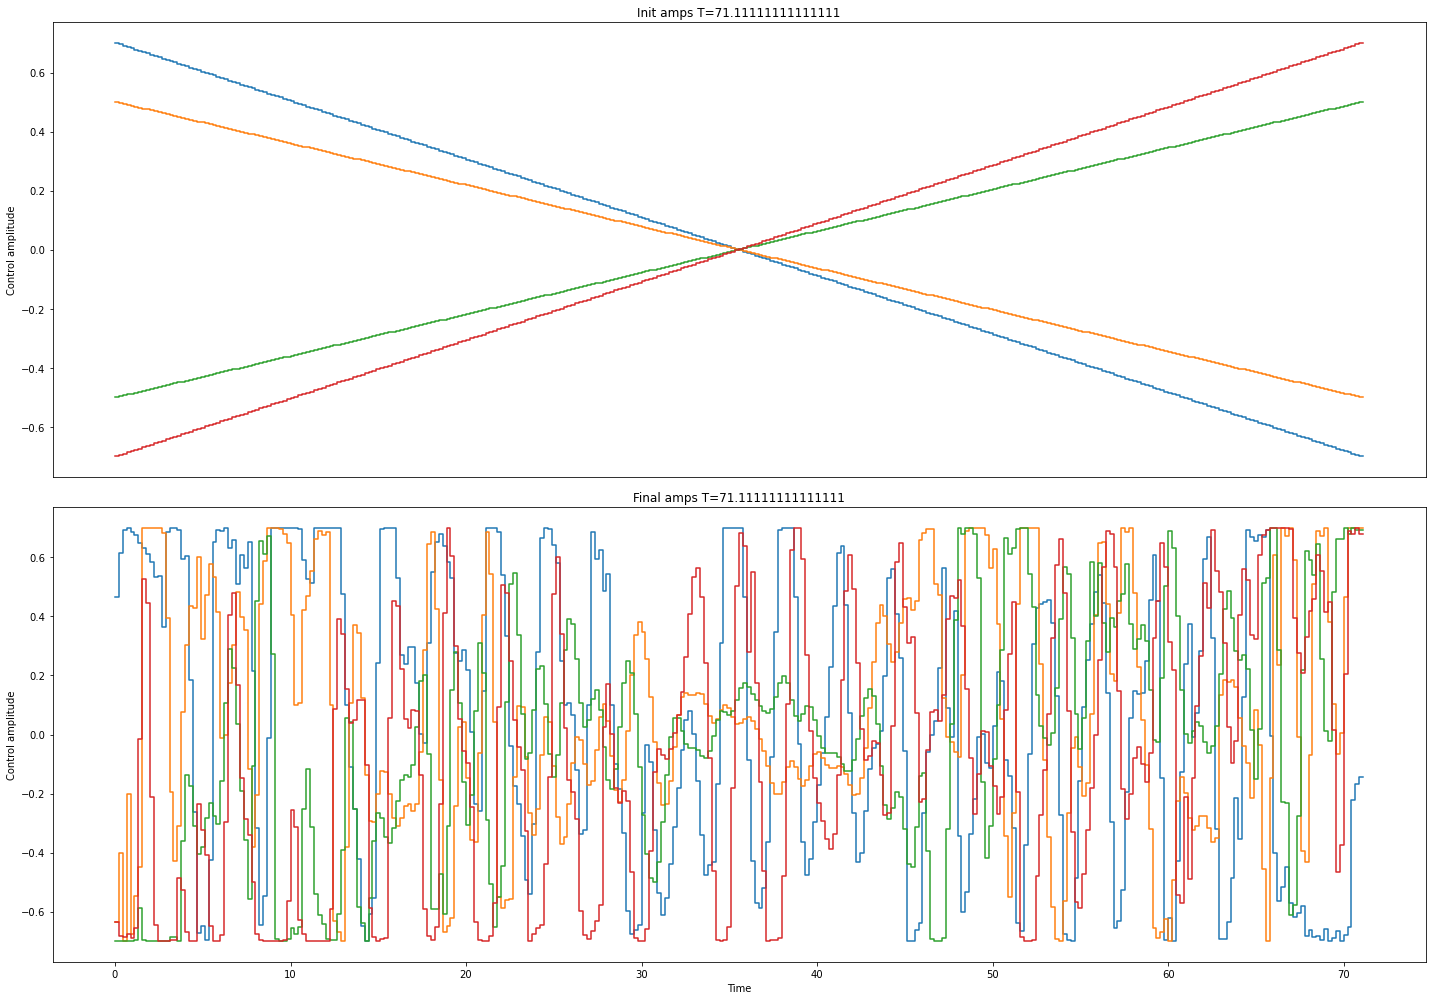

In [91]:
fig1 = plt.figure(figsize=(20,14))
for i in range(n_evo_times):
    #Initial amps
    ax1 = fig1.add_subplot(2, n_evo_times, i+1)
    ax1.set_title("Init amps T={}".format(evo_times[i]))
    # ax1.set_xlabel("Time")
    ax1.get_xaxis().set_visible(False)
    if i == 0:
        ax1.set_ylabel("Control amplitude")
    for j in range(n_ctrls):
        ax1.step(results[i].time, 
             np.hstack((results[i].initial_amps[:, j], 
                        results[i].initial_amps[-1, j])), 
                 where='post')
        
    ax2 = fig1.add_subplot(2, n_evo_times, i+n_evo_times+1)
    ax2.set_title("Final amps T={}".format(evo_times[i]))
    ax2.set_xlabel("Time")
    #Optimised amps
    if i == 0:
        ax2.set_ylabel("Control amplitude")
    for j in range(n_ctrls):
        ax2.step(results[i].time, 
             np.hstack((results[i].final_amps[:, j], 
                        results[i].final_amps[-1, j])), 
                 where='post')

plt.tight_layout()
plt.show()

### Versions

In [92]:
pulse_seq = results[0].final_amps
pulse_seq

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 0.46738098, -0.63624992, -0.7       , -0.63358358],
       [ 0.61517761, -0.40185939, -0.7       , -0.68343596],
       [ 0.69388629, -0.69994712, -0.7       , -0.68460209],
       ...,
       [-0.22327775,  0.7       ,  0.7       ,  0.68049038],
       [-0.16605512,  0.7       ,  0.69387955,  0.7       ],
       [-0.14378253,  0.7       ,  0.69300973,  0.6789739 ]])

### Run QuTip pulse simulation

In [93]:
processor = Processor(N=1, dims=[3 ** len(subsystem_list)])

dt = backend.configuration().dt * 1e9

# H_d = wq0 * (1 - sigmaz()) / 2
tlist = np.array([dt * i for i in range(len(pulse_seq) + 1)])
for i,control in enumerate(H_c):
    processor.add_control(control, targets=0)
    coef = [a[i] for a in pulse_seq]

    processor.pulses[i].coeff =  coef
    processor.pulses[i].tlist = tlist

# processor.pulses[0].coeff = seq_x
# processor.pulses[0].tlist = np.array([dt * i for i in range(len(seq_x)+1)])
# processor.add_control(H_c[0], targets=[0], label='sigmax')
# processor.add_control(H_d, targets=[0], label="drift")
processor.add_drift(H_d, targets=[0])

basis0 = basis(3 ** len(subsystem_list), 0)
# basis0 = basis(4,0) + basis(4,2)
result = processor.run_state(init_state=basis0)

result.states[-1].tidyup(1.e-3)

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[-0.34627863+0.44373281j]
 [-0.65733118-0.49740714j]
 [-0.01859255+0.j        ]
 [-0.00633073-0.02225666j]
 [ 0.02209836-0.01889298j]
 [ 0.03295956+0.01068624j]
 [-0.0100799 -0.00594162j]
 [-0.01288581+0.00893873j]
 [-0.0192358 -0.00369648j]]

### Create Channels and convert qoc pulses to Qiskit pulses

In [94]:
q1=0
q2=1

drive_chan1 = pulse.DriveChannel(q1)
meas_chan1 = pulse.MeasureChannel(q1)
acq_chan1 = pulse.AcquireChannel(q1)
con_chan1 = pulse.ControlChannel(q1)

drive_chan2 = pulse.DriveChannel(q2)
meas_chan2 = pulse.MeasureChannel(q2)
acq_chan2 = pulse.AcquireChannel(q2)
con_chan2 = pulse.ControlChannel(q2)


/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
pulse_seqs = []
for i,control in enumerate(H_c):
    coef = [a[i] for a in pulse_seq]
    pulse_seqs.append(coef)

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
pulse_seq
D0 = []
D1 = []
for a in pulse_seq:
    # amp1 = derotate(a[0])
    # amp2 = derotate(a[1])
    D0.append(complex(a[0], a[1]))
    # D0.append(amp1, amp2)
    D1.append(complex(a[2], a[3]))
    

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
schedule = pulse.Schedule(name='Frequency sweep')

# schedule += init_x

# later = schedule.duration

# schedule += def_cx << later
schedule += Play(SamplePulse(D0),drive_chan1) #<< schedule.duration
# schedule += Play(SamplePulse(D1),drive_chan2) #<< schedule.duration

from qiskit.pulse.macros import measure_all
schedule += measure_all(backend) << schedule.duration

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/benrosand/oct-qiskit-pulse/qiskit-terra/qiskit/pulse/library/sample_pulse.py:40: DeprecationWarning: SamplePulse has been renamed to Waveform and is deprecated. Please replace SamplePulse(samples, channel) with Waveform(samples, channel).
  warnings.warn("SamplePulse has been renamed to Waveform and is deprecated. " +


### Run the assembled pulse schedule

In [98]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=2,
                                   meas_return='single',
                                #    qubit_lo_freq=backend.defaults().qubit_freq_est,
                                   shots=num_shots_per_frequency,
                                   )
                                #    schedule_los=schedule_frequencies)



/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
job = backend.run(frequency_sweep_program)

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)


# job.result().get_counts()

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Job Status: job has successfully run


In [101]:
from src.helper import qubit_distribution
qubit_distribution(job.result().get_counts())

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{0: {0: 1011, 1: 13},
 1: {0: 1020, 1: 4},
 2: {0: 1019, 1: 5},
 3: {0: 957, 1: 67},
 4: {0: 307, 1: 717}}

In [102]:
from qiskit import QuantumCircuit

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
circ = QuantumCircuit(2)
circ.cnot(0,1)

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:


transp_circ = qiskit.transpile(circ, backend=backend)
transp_circ.data[0][0]

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'qiskit' is not defined

In [105]:
processor = Processor(N=1, dims=[9])

dt = backend.configuration().dt * 1e9

# H_d = wq0 * (1 - sigmaz()) / 2
tlist = np.array([dt * i for i in range(len(def_seq[0]) + 1)])
for i,control in enumerate(H_c):
    processor.add_control(control, targets=0)
    # coef = [a[i] for a in pulse_seq]

    processor.pulses[i].coeff = def_seq[i]
    processor.pulses[i].tlist = tlist

# processor.pulses[0].coeff = seq_x
# processor.pulses[0].tlist = np.array([dt * i for i in range(len(seq_x)+1)])
# processor.add_control(H_c[0], targets=[0], label='sigmax')
# processor.add_control(H_d, targets=[0], label="drift")
processor.add_drift(H_d, targets=[0])

basis0 = basis(9, 0)
# basis0 = basis(4,0) + basis(4,2)
result = processor.run_state(init_state=basis0)

result.states[-1].tidyup(1.e-3)

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'def_seq' is not defined